In [1]:
import datetime as dt
import os

import numpy as np
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from matplotlib.backends.backend_pdf import PdfPages

from src import update_databases
plt.style.use('./src/stylesheets/eb3.mplstyle')
from src.utilities import set_ticks, recolor_lines, export, din_a4
from src.project_definitions import dir_results

import locale
locale.setlocale(locale.LC_ALL,'de_DE')

##### READ Data #####
startdate = '2021-06-01'

print('Starte Import der Datensätze - das kann etwas dauern...')
from src.sensor_reader import AMB
print('...Import beendet')

10.03.2022 21:02:24 -- INFO -- ------ Starte TinkerForge Update------
10.03.2022 21:02:24 -- INFO -- LB wurde übersprungen.
10.03.2022 21:02:24 -- INFO -- MH wurde übersprungen.
10.03.2022 21:02:24 -- INFO -- MW wurde übersprungen.
10.03.2022 21:02:24 -- INFO -- WD wurde übersprungen.
10.03.2022 21:02:24 -- INFO -- PM wurde übersprungen.
10.03.2022 21:02:24 -- INFO -- ------TinkerForge Update beendet!------
10.03.2022 21:02:24 -- INFO -- Molline-Datenbank up-to-date. Kein Update notwendig.


Starte Import der Datensätze - das kann etwas dauern...
...Import beendet


In [2]:
ex = False

In [3]:
if not ex:
    # Monat
    focus = '3 2022'
    
    month, year = focus.split()
    focus_month = dt.date(int(year),int(month),1)

## Wetterdaten
____

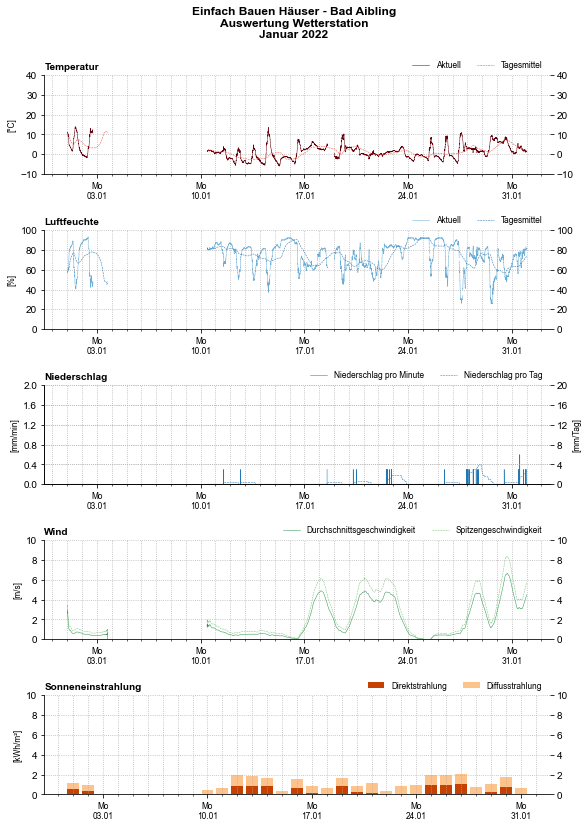

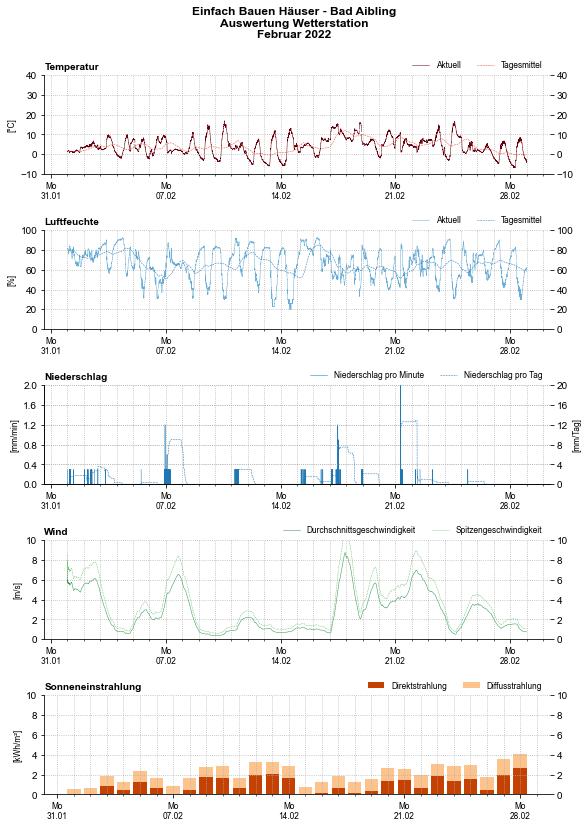

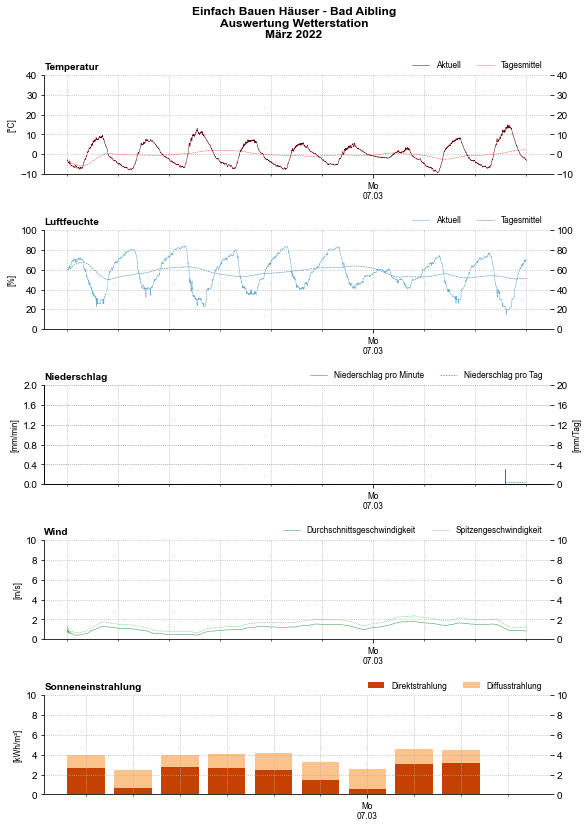

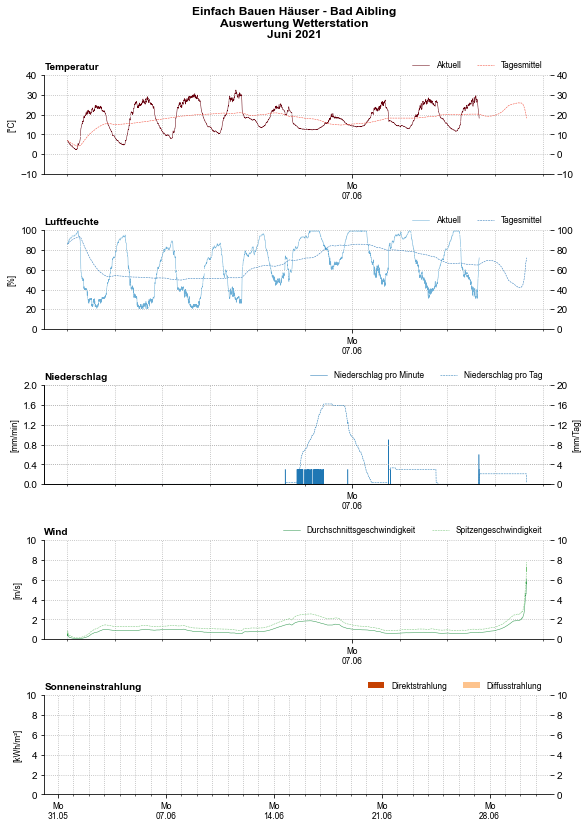

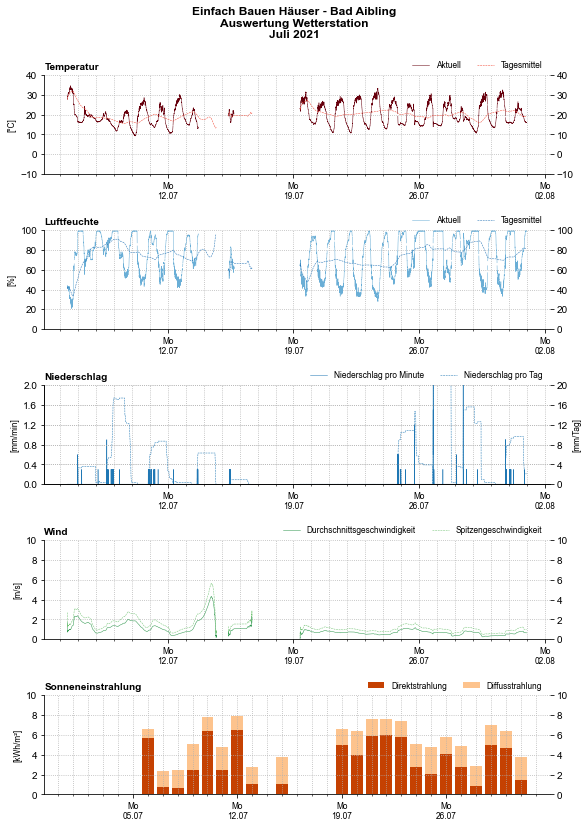

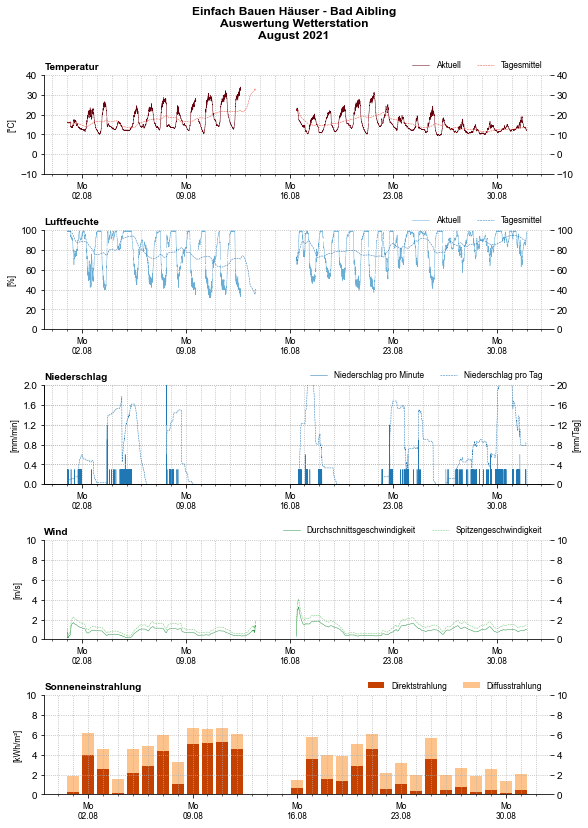

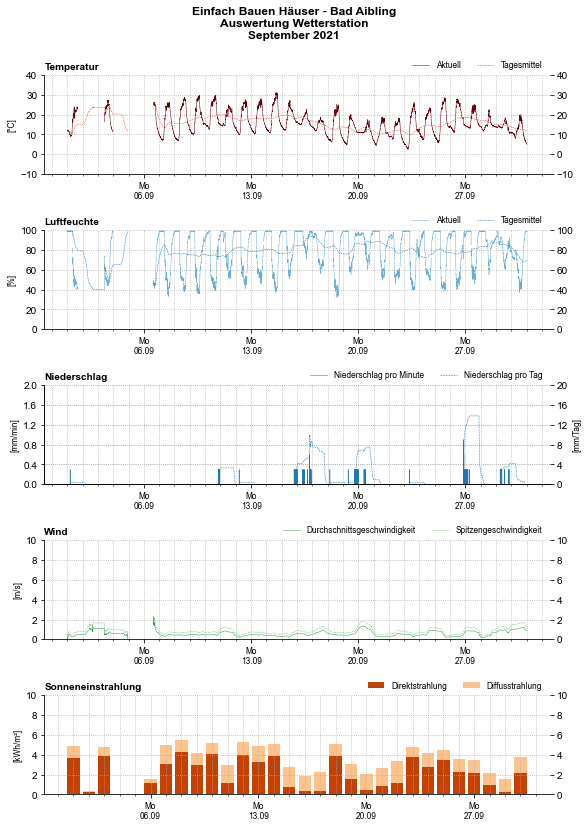

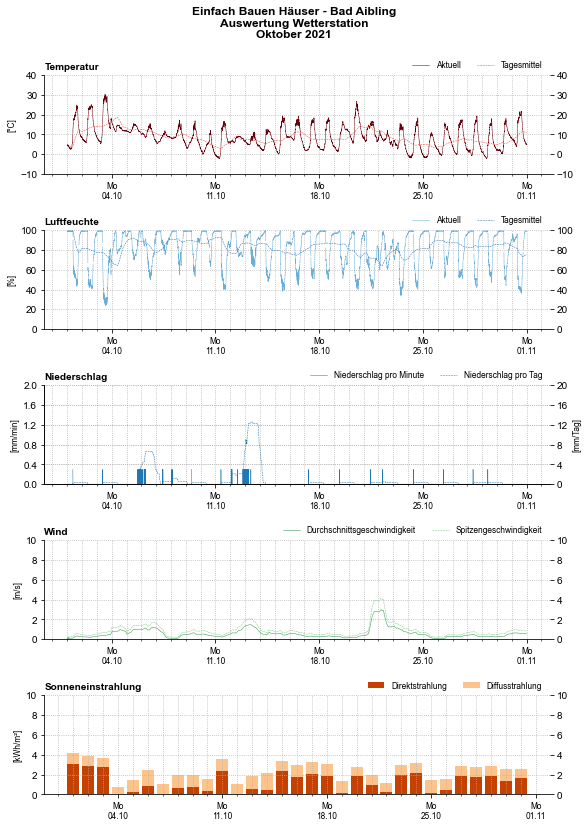

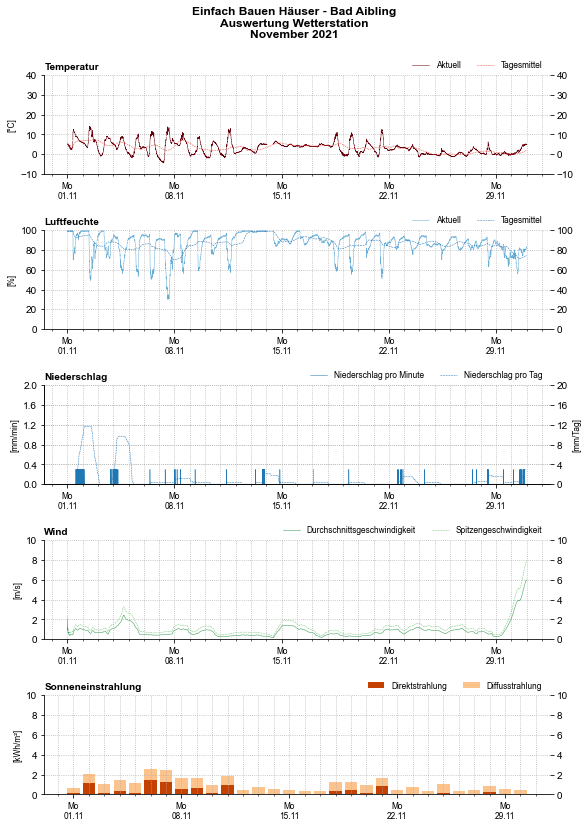

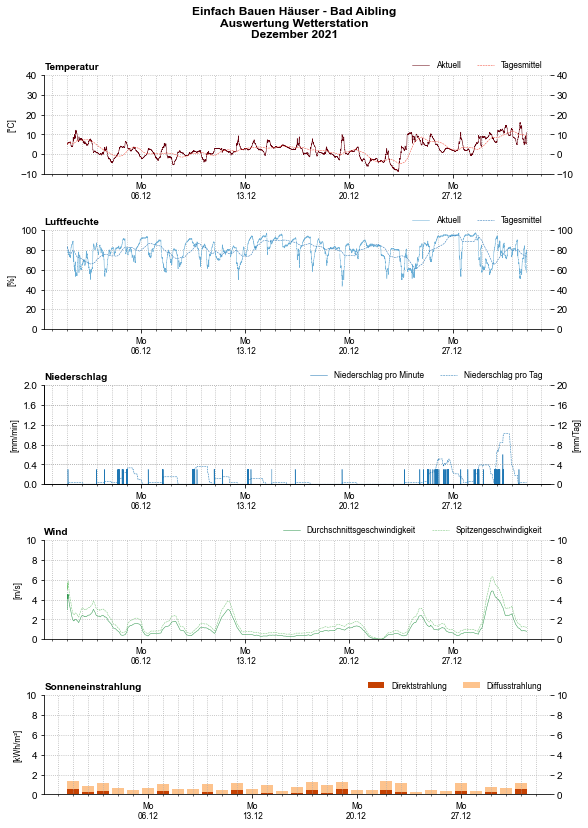

In [6]:
if not os.path.isdir(os.path.join(dir_results,'Wetterstation')):os.makedirs(os.path.join(dir_results,'Wetterstation'))
with PdfPages(os.path.join(dir_results,'Wetterstation','Wetter_monatlich.pdf')) as pdf:
    for date, amb in AMB.groupby(by=[AMB.index.month, AMB.index.year]):
        date = dt.date(date[1], date[0], 1)
        if not ex and date != focus_month:
            continue
        fig, axs = plt.subplots(5,1,figsize=din_a4)
        fig.suptitle(f'Einfach Bauen Häuser - Bad Aibling\nAuswertung Wetterstation\n{date.strftime("%B %Y")}\n', fontweight = 'bold')
        i=0
        #----#1: Temperaturen ----
        axs[i].set_title('Temperatur', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[°C]')
        set_ticks(axs[i],-10,40,10)
        axs[i].plot(amb.T_amb,label='Aktuell')
        axs[i].plot(amb.T_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
        recolor_lines(axs[i], 'Reds_r', 0 ,0.8)
        axs[i].grid(axis='y', ls = 'dotted')
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1
        #----#2: Luftfeuchte ----
        axs[i].set_title('Luftfeuchte', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[%]')
        set_ticks(axs[i],0,100,20)
        axs[i].plot(amb.Rh_amb,label='Aktuell')
        axs[i].plot(amb.Rh_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
        recolor_lines(axs[i], 'Blues', 0.5,1)
        axs[i].grid(axis='y', ls = 'dotted')
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1
        #----#3: Niederschlag ----
        # Plot aktueller Niederschlag (pro Minute)
        axs[i].set_title('Niederschlag', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[mm/min]')
        
        axs[i].plot(amb.rain.diff(),label='Niederschlag pro Minute')
        han,lab = axs[i].get_legend_handles_labels()
        axs[i].grid(axis='y', ls = 'dotted')
        i+=1

        #Plot summierter Niederschlag pro Tag

        axs = np.insert(axs,i,axs[i-1].twinx())
        axs[i].set_ylabel('[mm/Tag]')
        axs[i].plot(amb.rain.diff().rolling('D').sum(), linestyle='dashed',label='Niederschlag pro Tag')
        set_ticks(axs[i],0,20,4)
        set_ticks(axs[i-1], 0, 2, 0.4)
        han2,lab2 = axs[i].get_legend_handles_labels()
        lab += lab2
        han += han2
        axs[i].legend(labels = lab, handles = han, loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1
        #----#3: Wind ----

        axs[i].set_title('Wind', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[m/s]')
        axs[i].plot(amb.windspeed.rolling('D').mean(), label = 'Durchschnittsgeschwindigkeit')  
        axs[i].plot(amb.gustspeed.rolling('D').mean(),label = 'Spitzengeschwindigkeit',linestyle='dashed')  
        recolor_lines(axs[i], 'Greens_r', 0.3,0.7)
        axs[i].grid(axis='y', ls = 'dotted')
        set_ticks(axs[i],0,10,2)
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1

        #----#4: Globalstrahlung ----
        
        axs[i].set_title('Sonneneinstrahlung', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[kWh/m²]')
        set_ticks(axs[i],0,10,2)
        df_p = amb[['direct','diffuse']].resample('H').mean().resample('D').sum()/1000

        #axs[i].bar(df_p.index, df_p['global'], label='global', color=plt.cm.Accent(0), align='edge')
        #axs[i].bar(df_p.index,df_p['direct'],bottom = df_p['global'], label='direct',color=plt.cm.Accent(0.5))

        axs[i].bar(df_p.index, df_p['direct'], bottom = 0, color=plt.cm.Oranges(0.8), label = 'Direktstrahlung')
        axs[i].bar(df_p.index, df_p['diffuse'], bottom = df_p['direct'], color=plt.cm.Oranges(0.3), label = 'Diffusstrahlung')

        axs[i].grid(axis='y', ls = 'dotted')
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)

        for ax in axs:
            ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%d.%m'))
            ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
            ax.grid(axis='x',which='both', linestyle='dotted')
            ax.spines['bottom'].set_visible(True)
            
        fig.tight_layout()
        pdf.savefig(fig)
        if not ex: break

In [7]:
winddir = {'E':4, 'ENE':3, 'ESE':5, 'N':0, 'NE':2, 'NNE':1, 'NNW':15, 'NW':14, 'S':8, 'SE':6, 'SSE':7,
       'SSW':9, 'SW':10, 'W':12, 'WNW':13, 'WSW':11}
winddir = dict(sorted(winddir.items(), key=lambda item: item[1]))
wind = dict(zip(winddir.keys(), np.linspace(0,2*np.pi,16,endpoint=False)))

W =  AMB.loc[:,['winddir','windspeed','gustspeed']]
W['dir'] = W.winddir.replace(wind)

bins = np.linspace(W.windspeed.min(), W.windspeed.max(), 6)
labels = ['{} - {} m/s'.format(round(bins[i-1],1),round(bins[i],1)) for i in range(1,6)]

columns = ['bin{}'.format(i) for i in range(6)]
rose = pd.DataFrame(index=W.winddir.value_counts().index, columns=columns)

for i in range(1,6):
    rose[columns[i]] = W[(W.windspeed > bins[i-1]) & (W.windspeed <= bins[i])].groupby("winddir").size()/W.groupby('winddir').size().sum()
rose = rose*100

rose['theta'] = rose.index
rose.theta.replace(wind,inplace=True)
rose['deg'] =  rose.theta.apply(np.rad2deg)
rose.replace(np.nan,0,inplace=True)

fig, ax = plt.subplots(figsize = (6,6), subplot_kw={'projection': 'polar'})

fig.suptitle('Windrose',fontweight='bold')

w = 2*np.pi/(16)

_colors = plt.cm.Accent(np.linspace(0,1,5))

ax.bar(rose.theta,rose.bin1,width = w, bottom=0, label = labels[0],color=_colors[0],alpha=0.75)
ax.bar(rose.theta,rose.bin2,width = w, bottom=rose.bin1, label = labels[1],color=_colors[1],alpha=0.75)
ax.bar(rose.theta,rose.bin3,width = w, bottom=rose.bin1+rose.bin2, label = labels[2],color=_colors[2],alpha=0.75)
ax.bar(rose.theta,rose.bin4,width = w, bottom=rose.bin1+rose.bin2+rose.bin3, label = labels[3],color=_colors[3],alpha=0.75)
ax.bar(rose.theta,rose.bin5,width = w, bottom=rose.bin1+rose.bin2+rose.bin3+rose.bin4, label = labels[4],color=_colors[4],alpha=0.75)

ax.set_theta_direction(-1)

ax.set_xticks(np.linspace(0,2*np.pi,4,endpoint=False))
ax.set_xticks(np.linspace(0,2*np.pi,4,endpoint=False)+0.25*np.pi,minor=True)
ax.set_xticklabels(['NO','SO','SW','NW'],minor=True)
ax.set_xticklabels(['Nord','Ost','Süd','West'],fontweight='bold')

ax.set_theta_zero_location('N')

ax.grid(linestyle='dashed')
ax.grid(linestyle='dotted',which='minor')

ax.set_rlabel_position(60)
ax.legend(loc=3,frameon=True)
ax.yaxis.set_major_locator(ticker.FixedLocator([5,10,15,20]))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

fig.tight_layout()

if ex:
    export(fig,filepath=os.path.join(dir_results,'Wetterstation'),filename='Windrose', extlist=['pdf'])

C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Wetterstation\Windrose.pdf saved!
